## Things to implement:
<ul>
<li>Focal Loss <b>[DONE]</b></li> 
<li>Undersampling of the "O" tags <b>[DONE]</b></li> 
<li><b>[OPTIONAL]</b> <s>SMOTE with Undersampling</s> ADASYN
</ul>

# Importing the Libraries

In [1]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.utils import shuffle, class_weight
import seaborn as sns
import pandas as pd
import numpy as np
# from focal_loss import FocalLoss
from imblearn.over_sampling import ADASYN
from math import sqrt

# Importing the relevant files
train_file = '../../Data/NCBItrainset_corpus.txt'
dev_file = '../../Data/NCBIdevelopset_corpus.txt'
model_name = '../../Models/BiLSTM_CrossAttention_NER_model.pth'
test_file = '../../Data/NCBItestset_corpus.txt'
unknown_token = "<UNK>"

# Data Preparation

In [2]:
# Reading and parsing the dataset file
def read_dataset(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines

def parse_dataset(lines):
    paragraphs, paragraph = [], []
    for line in lines:
        line = line.strip()
        if line:
            paragraph.append(line)
        else:
            if paragraph:
                paragraphs.append(paragraph)
                paragraph = []
    if paragraph:
        paragraphs.append(paragraph)
    return paragraphs

In [3]:
def parse_paragraph(paragraph):
    sentences, annotations, sentence = [], [], []
    for line in paragraph:
        if re.match(r'^\d+\|\w\|', line):
            sentence.extend(line.split('|')[2].split())
        elif re.match(r'^\d+\t\d+\t\d+\t', line):
            start, end = int(line.split("\t")[1]), int(line.split("\t")[2])
            annotations.append((start, end, line.split("\t")[3], line.split("\t")[4]))
    if sentence:
        sentences.append(sentence)
    return sentences, annotations

## Tagging the words based on character limits

In [4]:
def tag_annotations(sentences, annotations):
    tagged_sentences = []
    for sentence in sentences:
        tags = ['O'] * len(sentence)
        word_starts, word_ends, char_pos = [], [], 0
        for word in sentence:
            word_starts.append(char_pos)
            char_pos += len(word)
            word_ends.append(char_pos)
            char_pos += 1
        for start, end, _, label in annotations:
            for i, (word_start, word_end) in enumerate(zip(word_starts, word_ends)):
                if word_start >= start and word_end <= end:
                    if label == 'Modifier' or label == 'DiseaseClass':
                        tags[i] = 'I-' + 'SpecificDisease'
                    else:
                        tags[i] = 'I-' + label
                elif word_start < start < word_end or word_start < end < word_end:
                    if label == 'Modifier' or label == 'DiseaseClass':
                        tags[i] = 'I-' + 'SpecificDisease'
                    else:
                        tags[i] = 'I-' + label
        tagged_sentences.append((sentence, tags))
    return tagged_sentences

## Assigning Data

#### Note: The Training and Validation datasets are merged, and a 80-20 split with a shuffle is performed

In [5]:
# Prepare the combined dataset
def prepare_combined_dataset(train_file, dev_file):
    lines = read_dataset(train_file)
    paragraphs = parse_dataset(lines)
    all_sentences, all_tags = [], []
    for paragraph in paragraphs:
        s, a = parse_paragraph(paragraph)
        tagged_sentences = tag_annotations(s, a)
        for sentence, tag in tagged_sentences:
            all_sentences.append(sentence)
            all_tags.append(tag)

    dev_lines = read_dataset(dev_file)
    dev_paragraphs = parse_dataset(dev_lines)
    for dev_paragraph in dev_paragraphs:
        dev_s, dev_a = parse_paragraph(dev_paragraph)
        dev_tagged_sentences = tag_annotations(dev_s, dev_a)
        for dev_sentence, dev_tag in dev_tagged_sentences:
            all_sentences.append(dev_sentence)
            all_tags.append(dev_tag)

    return all_sentences, all_tags

all_sentences, all_tags = prepare_combined_dataset(train_file, dev_file)

In [6]:
# Modify the Dataset class to count <UNK> tokens and use ADASYN
class LSTM_Attention_NERDataset(Dataset):
    def __init__(self, sentences, tags, word_encoder, tag_encoder, unknown_token='<UNK>'):
        self.sentences = sentences
        self.tags = tags
        self.word_encoder = word_encoder
        self.tag_encoder = tag_encoder
        self.unknown_token = unknown_token
        self.unk_count = 0
        self.unk_tags = []
        self.adasyn_resample()
        
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]
        sentence_encoded = [self.word_encoder.get(word, self.word_encoder[self.unknown_token]) for word in sentence]
        
        # Count <UNK> tokens and collect their tags
        for word, tag in zip(sentence, tags):
            if word not in self.word_encoder:
                self.unk_count += 1
                self.unk_tags.append(tag)
        
        tags_encoded = self.tag_encoder.transform(tags)
        return torch.tensor(sentence_encoded), torch.tensor(tags_encoded, dtype=torch.long)

    def adasyn_resample(self):
        flattened_sentences = [word for sentence in self.sentences for word in sentence]
        flattened_tags = [tag for tags in self.tags for tag in tags]
        encoded_sentences = np.array([self.word_encoder.get(word, self.word_encoder[self.unknown_token]) for word in flattened_sentences]).reshape(-1, 1)
        encoded_tags = np.array(self.tag_encoder.transform(flattened_tags))
        
        adasyn = ADASYN(sampling_strategy='minority')
        resampled_sentences, resampled_tags = adasyn.fit_resample(encoded_sentences, encoded_tags)
        
        # Split resampled data back into sentences
        sentence_lengths = [len(sentence) for sentence in self.sentences]
        new_sentences, new_tags = [], []
        
        start_idx = 0
        for length in sentence_lengths:
            end_idx = start_idx + length
            new_sentences.append(resampled_sentences[start_idx:end_idx].flatten().tolist())
            new_tags.append(resampled_tags[start_idx:end_idx].flatten().tolist())
            start_idx = end_idx
        
        self.sentences = [[list(self.word_encoder.keys())[idx] for idx in sentence] for sentence in new_sentences]
        self.tags = [[self.tag_encoder.inverse_transform([tag])[0] for tag in tags] for tags in new_tags]

In [7]:
# A train test split to divide the data into a training and testing (but actually validation data) sets
train_sentences, val_sentences, train_tags, val_tags = train_test_split(all_sentences, all_tags, shuffle=True, test_size=0.2, random_state=42)

In [8]:
all_words = [word for sentence in all_sentences for word in sentence]
all_tags_flat = [tag for tags in all_tags for tag in tags]

word_encoder = {word: idx for idx, word in enumerate(set(all_words))}
unknown_token = '<UNK>'
word_encoder[unknown_token] = len(word_encoder)

tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags_flat)

dataset = LSTM_Attention_NERDataset(train_sentences, train_tags, word_encoder, tag_encoder, unknown_token)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)

val_dataset = LSTM_Attention_NERDataset(val_sentences, val_tags, word_encoder, tag_encoder, unknown_token)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)

# Display the counts and tags of <UNK> tokens
print(f"Number of <UNK> tokens in the training dataset: {dataset.unk_count}")
print(f"Tags of <UNK> tokens in the training dataset: {Counter(dataset.unk_tags)}")

print(f"Number of <UNK> tokens in the validation dataset: {val_dataset.unk_count}")
print(f"Tags of <UNK> tokens in the validation dataset: {Counter(val_dataset.unk_tags)}")

Number of <UNK> tokens in the training dataset: 0
Tags of <UNK> tokens in the training dataset: Counter()
Number of <UNK> tokens in the validation dataset: 0
Tags of <UNK> tokens in the validation dataset: Counter()


# Cross Attention Class Definition

In [9]:
class CrossAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.key = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value):
        query_proj = self.query(query)
        key_proj = self.key(key)
        value_proj = self.value(value)
        attention_scores = torch.matmul(query_proj, key_proj.transpose(-2, -1))
        attention_weights = self.softmax(attention_scores)
        context = torch.matmul(attention_weights, value_proj)
        return context

In [10]:
class BiLSTM_CrossAttention_NER_Model(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=128, dropout_prob=0.35):
        super(BiLSTM_CrossAttention_NER_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.batch_norm_emb = nn.BatchNorm1d(embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=dropout_prob)
        self.cross_attention = CrossAttention(hidden_dim * 2)
        self.batch_norm_att = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x):
        emb = self.embedding(x)
        emb = self.batch_norm_emb(emb.transpose(1, 2)).transpose(1, 2)
        emb = self.dropout(emb)
        
        bilstm_out, _ = self.bilstm(emb)
        bilstm_out = self.dropout(bilstm_out)
        
        cross_att_out = self.cross_attention(bilstm_out, bilstm_out, bilstm_out)
        cross_att_out = self.batch_norm_att(cross_att_out.transpose(1, 2)).transpose(1, 2)
        cross_att_out = self.dropout(cross_att_out)
        
        tag_space = self.fc(cross_att_out)
        return tag_space

### Defining the Focal Class (to be used in the case of highly imbalanced datasets of around 1:1000)

In [11]:
class Focal_Loss (nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, ignore_index=-100):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, outputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction = 'none', ignore_index = self.ignore_index)(outputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1-pt) ** self.gamma) * ce_loss

        return focal_loss.mean()

# Training Model Parameters

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_sentences = list(all_sentences)
all_tags = list(all_tags)
fold = 1

cuda


### Graph Plotting Function

In [13]:
# Plot Training and Validation Loss for each fold
def plot_kfold_losses(training_losses, validation_losses, fold):
    plt.plot(list(training_losses.keys()), list(training_losses.values()), label=f'Train Fold {fold + 1}')
    plt.plot(list(validation_losses.keys()), list(validation_losses.values()), label=f'Val Fold {fold + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Each Fold')
    plt.legend()
    plt.savefig("../../Graphs/aBiLSTM_CrossAttention_KFold.png", bbox_inches='tight')
    plt.show()

# Training the Model

Fold 1
Epoch 1, Average Training Loss: 0.3377, Validation Loss: 0.1559
Epoch 2, Average Training Loss: 0.1797, Validation Loss: 0.1470
Epoch 3, Average Training Loss: 0.1687, Validation Loss: 0.1470
Epoch 4, Average Training Loss: 0.1634, Validation Loss: 0.1461
Epoch 5, Average Training Loss: 0.1716, Validation Loss: 0.1464
Epoch 6, Average Training Loss: 0.1664, Validation Loss: 0.1474
Epoch 7, Average Training Loss: 0.1658, Validation Loss: 0.1465
Epoch 8, Average Training Loss: 0.1662, Validation Loss: 0.1457
Epoch 9, Average Training Loss: 0.1683, Validation Loss: 0.1455
Epoch 10, Average Training Loss: 0.1590, Validation Loss: 0.1459
Epoch 11, Average Training Loss: 0.1614, Validation Loss: 0.1451
Epoch 12, Average Training Loss: 0.1613, Validation Loss: 0.1453
Epoch 13, Average Training Loss: 0.1642, Validation Loss: 0.1429
Epoch 14, Average Training Loss: 0.1681, Validation Loss: 0.1434
Epoch 15, Average Training Loss: 0.1632, Validation Loss: 0.1430
Epoch 16, Average Training 

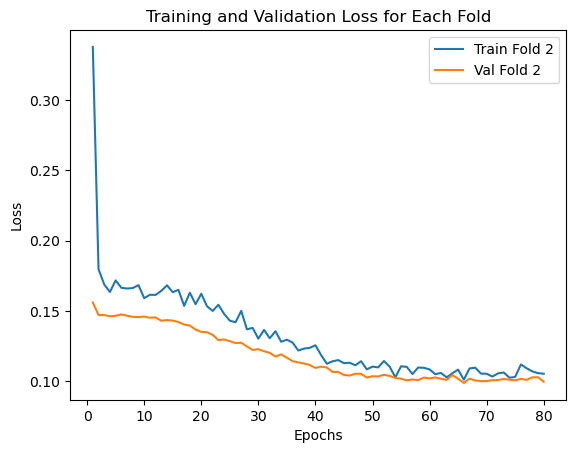

Fold 2
Epoch 1, Average Training Loss: 0.4371, Validation Loss: 0.1822
Epoch 2, Average Training Loss: 0.1783, Validation Loss: 0.1771
Epoch 3, Average Training Loss: 0.1595, Validation Loss: 0.1727
Epoch 4, Average Training Loss: 0.1660, Validation Loss: 0.1728
Epoch 5, Average Training Loss: 0.1621, Validation Loss: 0.1727
Epoch 6, Average Training Loss: 0.1677, Validation Loss: 0.1713
Epoch 7, Average Training Loss: 0.1607, Validation Loss: 0.1723
Epoch 8, Average Training Loss: 0.1603, Validation Loss: 0.1706
Epoch 9, Average Training Loss: 0.1543, Validation Loss: 0.1699
Epoch 10, Average Training Loss: 0.1697, Validation Loss: 0.1703
Epoch 11, Average Training Loss: 0.1578, Validation Loss: 0.1714
Epoch 12, Average Training Loss: 0.1637, Validation Loss: 0.1680
Epoch 13, Average Training Loss: 0.1620, Validation Loss: 0.1699
Epoch 14, Average Training Loss: 0.1617, Validation Loss: 0.1697
Epoch 15, Average Training Loss: 0.1537, Validation Loss: 0.1694
Epoch 16, Average Training 

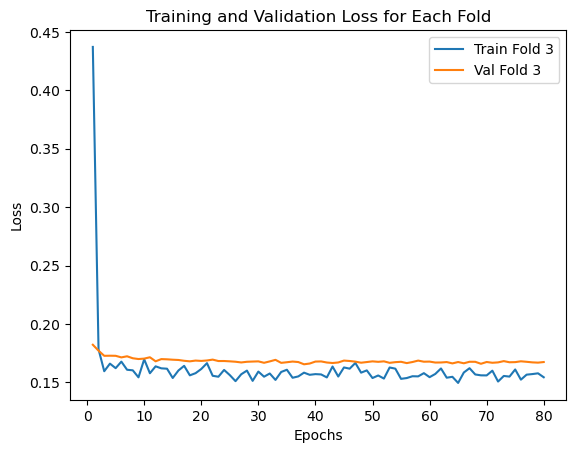

Fold 3
Epoch 1, Average Training Loss: 0.3594, Validation Loss: 0.1812
Epoch 2, Average Training Loss: 0.1900, Validation Loss: 0.1676
Epoch 3, Average Training Loss: 0.1713, Validation Loss: 0.1653
Epoch 4, Average Training Loss: 0.1602, Validation Loss: 0.1668
Epoch 5, Average Training Loss: 0.1703, Validation Loss: 0.1681
Epoch 6, Average Training Loss: 0.1636, Validation Loss: 0.1660
Epoch 7, Average Training Loss: 0.1657, Validation Loss: 0.1652
Epoch 8, Average Training Loss: 0.1710, Validation Loss: 0.1645
Epoch 9, Average Training Loss: 0.1645, Validation Loss: 0.1654
Epoch 10, Average Training Loss: 0.1652, Validation Loss: 0.1641
Epoch 11, Average Training Loss: 0.1621, Validation Loss: 0.1639
Epoch 12, Average Training Loss: 0.1617, Validation Loss: 0.1644
Epoch 13, Average Training Loss: 0.1711, Validation Loss: 0.1656
Epoch 14, Average Training Loss: 0.1656, Validation Loss: 0.1652
Epoch 15, Average Training Loss: 0.1589, Validation Loss: 0.1641
Epoch 16, Average Training 

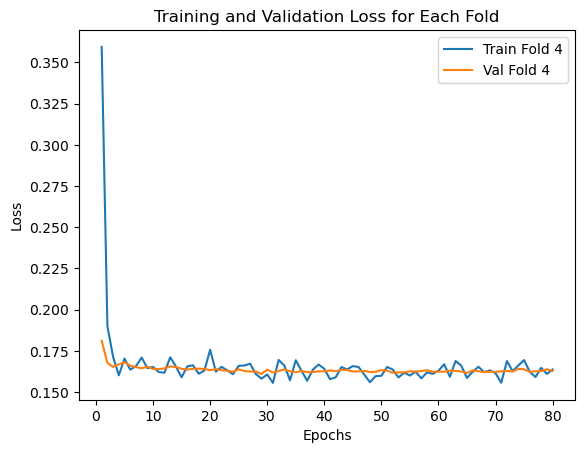

Fold 4
Epoch 1, Average Training Loss: 0.4454, Validation Loss: 0.1994
Epoch 2, Average Training Loss: 0.1779, Validation Loss: 0.1847
Epoch 3, Average Training Loss: 0.1682, Validation Loss: 0.1792
Epoch 4, Average Training Loss: 0.1614, Validation Loss: 0.1796
Epoch 5, Average Training Loss: 0.1676, Validation Loss: 0.1771
Epoch 6, Average Training Loss: 0.1628, Validation Loss: 0.1770
Epoch 7, Average Training Loss: 0.1587, Validation Loss: 0.1788
Epoch 8, Average Training Loss: 0.1616, Validation Loss: 0.1760
Epoch 9, Average Training Loss: 0.1602, Validation Loss: 0.1754
Epoch 10, Average Training Loss: 0.1634, Validation Loss: 0.1762
Epoch 11, Average Training Loss: 0.1560, Validation Loss: 0.1746
Epoch 12, Average Training Loss: 0.1484, Validation Loss: 0.1736
Epoch 13, Average Training Loss: 0.1593, Validation Loss: 0.1716
Epoch 14, Average Training Loss: 0.1477, Validation Loss: 0.1663
Epoch 15, Average Training Loss: 0.1364, Validation Loss: 0.1617
Epoch 16, Average Training 

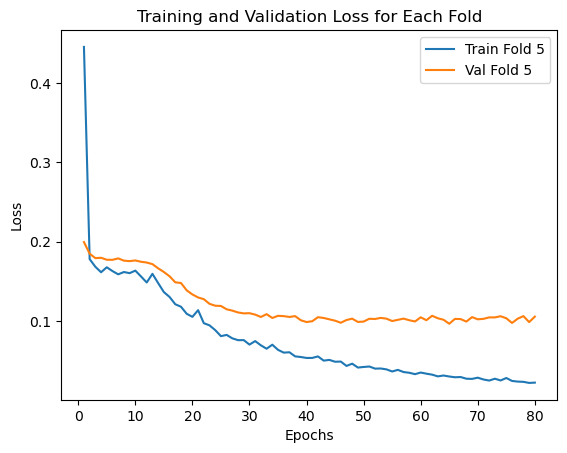

Fold 5
Epoch 1, Average Training Loss: 0.3290, Validation Loss: 0.1857
Epoch 2, Average Training Loss: 0.1731, Validation Loss: 0.1745
Epoch 3, Average Training Loss: 0.1718, Validation Loss: 0.1723
Epoch 4, Average Training Loss: 0.1671, Validation Loss: 0.1744
Epoch 5, Average Training Loss: 0.1608, Validation Loss: 0.1762
Epoch 6, Average Training Loss: 0.1616, Validation Loss: 0.1718
Epoch 7, Average Training Loss: 0.1594, Validation Loss: 0.1745
Epoch 8, Average Training Loss: 0.1698, Validation Loss: 0.1716
Epoch 9, Average Training Loss: 0.1590, Validation Loss: 0.1759
Epoch 10, Average Training Loss: 0.1610, Validation Loss: 0.1726
Epoch 11, Average Training Loss: 0.1696, Validation Loss: 0.1684
Epoch 12, Average Training Loss: 0.1519, Validation Loss: 0.1697
Epoch 13, Average Training Loss: 0.1492, Validation Loss: 0.1619
Epoch 14, Average Training Loss: 0.1496, Validation Loss: 0.1559
Epoch 15, Average Training Loss: 0.1401, Validation Loss: 0.1479
Epoch 16, Average Training 

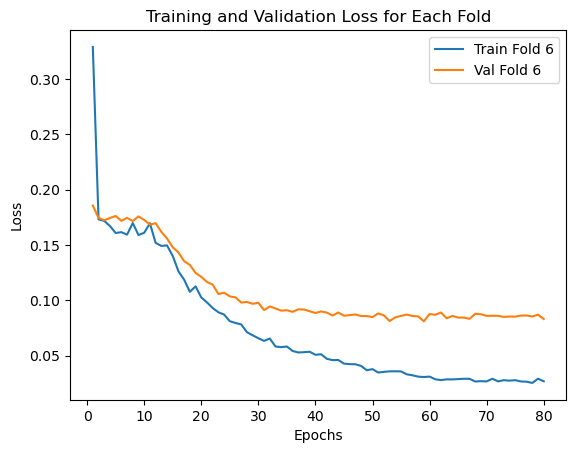

In [14]:
for (train_index, val_index) in kf.split(train_sentences):
    print(f"Fold {fold}")
    
    t_sentences = [train_sentences[i] for i in train_index]
    dev_sentences = [train_sentences[i] for i in val_index]
    t_tags = [train_tags[i] for i in train_index]
    dev_tags = [train_tags[i] for i in val_index]

    print(f"Number of training tags in fold {fold}: {sum(len(tags) for tags in t_tags)}")
    print(f"Number of validation tags in fold {fold}: {sum(len(tags) for tags in dev_tags)}")

    t_dataset = LSTM_Attention_NERDataset(t_sentences, t_tags, word_encoder, tag_encoder, unknown_token)
    dev_dataset = LSTM_Attention_NERDataset(dev_sentences, dev_tags, word_encoder, tag_encoder, unknown_token)

    train_dataloader = DataLoader(t_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: x)
    dev_dataloader = DataLoader(dev_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: x)

    model = BiLSTM_CrossAttention_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
    criterion = Focal_Loss(alpha=0.95, gamma=0, ignore_index=-100) # See if the Focal Loss makes any difference
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.4)
    scaler = torch.cuda.amp.GradScaler()

    model.train()
    loss_dic = {}
    valid_loss_dic = {}

    for epoch in range(80):
        total_loss = 0
        total_valid_loss = 0

        for batch in train_dataloader:
            sentences, tags = zip(*batch)
            sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
            tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(sentences)
                outputs = outputs.view(-1, outputs.shape[-1])
                tags = tags.view(-1)
                loss = criterion(outputs, tags)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)

        with torch.no_grad():
            for batch in dev_dataloader:
                dev_sentences, dev_tags = zip(*batch)
                dev_sentences = torch.nn.utils.rnn.pad_sequence(dev_sentences, batch_first=True).to(device)
                dev_tags = torch.nn.utils.rnn.pad_sequence(dev_tags, batch_first=True, padding_value=-100).to(device)

                with torch.cuda.amp.autocast():
                    val_outputs = model(dev_sentences)
                    val_outputs = val_outputs.view(-1, val_outputs.shape[-1])
                    dev_tags = dev_tags.view(-1)
                    valid_loss = criterion(val_outputs, dev_tags)
                    total_valid_loss += valid_loss.item()
        
        avg_valid_loss = total_valid_loss / len(dev_dataloader)

        scheduler.step(avg_train_loss)

        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
        loss_dic[epoch + 1] = avg_train_loss
        valid_loss_dic[epoch + 1] = avg_valid_loss
    plot_kfold_losses(loss_dic, valid_loss_dic, fold)
    fold += 1

In [15]:
# Saving the model
torch.save(model.state_dict(), model_name)

# Testing the Model
### (On the remaing 20 dataset)

In [16]:
# We have the val_dataset and val_dataloader
# Also val_sentences and val_dataloader

In [17]:
# # Testing the model, and evaluating the f1 score
# test_lines = read_dataset(test_file)
# test_paragraphs = parse_dataset(test_lines)

In [18]:
# # Parsing and storing the test dataset
# test_sentences = []
# test_tags = []

# for paragraph in test_paragraphs:
#     sentences, annotations = parse_paragraph(paragraph)
#     tagged_sentences = tag_annotations(sentences, annotations)
#     for sentence, tags in tagged_sentences:
#         test_sentences.append(sentence)
#         test_tags.append(tags)

In [19]:
# Importing the model file
model = BiLSTM_CrossAttention_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
model.load_state_dict(torch.load(model_name))
model.eval()

BiLSTM_CrossAttention_NER_Model(
  (embedding): Embedding(16290, 128)
  (batch_norm_emb): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bilstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (cross_attention): CrossAttention(
    (query): Linear(in_features=256, out_features=256, bias=False)
    (key): Linear(in_features=256, out_features=256, bias=False)
    (value): Linear(in_features=256, out_features=256, bias=False)
    (softmax): Softmax(dim=-1)
  )
  (batch_norm_att): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [20]:
# # Prepare the test data
# test_dataset = LSTM_Attention_NERDataset(test_sentences, test_tags, word_encoder, tag_encoder, '<UNK>')
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: x)

# # Display the counts and tags of <UNK> tokens
# print(f"Number of <UNK> tokens in the testing dataset: {test_dataset.unk_count}")
# print(f"Tags of <UNK> tokens in the testing dataset: {Counter(test_dataset.unk_tags)}")

# Evaluate the model
all_true_labels = []
all_pred_labels = []

single_word_list = []

for i in val_sentences:
    for j in i:
        single_word_list.append(j)

result = "../../Result/TestResults_CrossAttention_BiLSTM_NER.txt"
with open(result, 'w') as t_file:
    with torch.no_grad():
        for batch in val_dataloader:
            sentences, tags = zip(*batch)
            sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
            tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

            outputs = model(sentences)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)

            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            true_labels = tags.cpu().numpy()

            mask = true_labels != -100
            pred_labels = predictions[mask]
            true_labels = true_labels[mask]

            pred_labels_decoded = tag_encoder.inverse_transform(pred_labels)
            true_labels_decoded = tag_encoder.inverse_transform(true_labels)
            
            for word, true_label, pred_label in zip(single_word_list, true_labels_decoded, pred_labels_decoded):
                t_file.write(f'Word: {word}, True: {true_label}, Pred: {pred_label}\n')
                all_true_labels.append(true_label)
                all_pred_labels.append(pred_label)

# Printing classification report
report = classification_report(all_true_labels, all_pred_labels)
print (report)

                    precision    recall  f1-score   support

I-CompositeMention       0.60      0.44      0.50       163
 I-SpecificDisease       0.86      0.69      0.76      2306
                 O       0.97      0.99      0.98     24360

          accuracy                           0.96     26829
         macro avg       0.81      0.70      0.75     26829
      weighted avg       0.96      0.96      0.96     26829



In [21]:
'''
Testing the G_Mean based on the heatmap of Confusion Matrix
'''
precision = precision_score(all_true_labels, all_pred_labels, average = None)
recall = recall_score(all_true_labels, all_pred_labels, average = None)
print(precision)
print(recall)
g_mean = []
G_Mean = 0
for p, r in zip(precision, recall):
    class_gmean = sqrt(p*r)
    g_mean.append(class_gmean)
    G_Mean += class_gmean

G_Mean /= len(precision)
print (G_Mean)
print(g_mean)

## Calculating the overall accuracy of the model

In [22]:
# file_path = "../../Result/TestResults_CrossAttention_BiLSTM_NER.txt"

# true_tags = []
# pred_tags = []

# with open(file_path, "r") as res_file:
#     for line in res_file:
#         if 'True:' in line and 'Pred:' in line:
#             parts = line.split(', ')
#             true_la = parts[0].split(': ')[1]
#             pred_la = parts[1].split(': ')[1]

#             true_tags.append(true_la)
#             pred_tags.append(pred_la)

# labels = sorted(list(set(true_tags) | set(pred_tags)))
# c_mat = confusion_matrix(true_tags, pred_tags, labels=labels)
# print(c_mat)

### Normalize the Confusion Matrix

In [23]:
# c_mat_norm = c_mat.astype('float') / c_mat.sum(axis = 1)[: , np.newaxis]
# c_mat_norm

In [24]:
# # Create a heatmap
# plt.figure(figsize=(10,8))
# sns.heatmap(c_mat_norm, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap='coolwarm', square=True)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title("Normalized Confusion Matrix")
# plt.show()

In [25]:
# len()